In [1]:
%matplotlib inline
%pylab inline

from functools import partial
import  matplotlib.pyplot as plt

import menpo.io as mio
from menpo.feature import imgfeature, fast_dsift
from menpo.landmark import labeller, ibug_face_68_trimesh
from menpo.visualize import visualize_images, print_dynamic, plot_graph
from menpo.visualize.viewmatplotlib import sample_colours_from_colourmap

from menpofit.result import compute_normalise_point_to_point_error, compute_cumulative_error
from menpofit.aam import (
    HolisticAAM, LucasKanadeAAMFitter, 
    holistic_sampling_from_scale,  holistic_sampling_from_step)
from menpofit.aam.algorithm.lk_alabort_arxiv2015 import (
    SSDForwardGaussNewtonSimultaneous,
    SSDForwardGaussNewtonAlternated,
    SSDInverseGaussNewtonSimultaneous,
    SSDInverseGaussNewtonAlternated,
    SSDAsymmetricGaussNewtonSimultaneous,
    SSDAsymmetricGaussNewtonAlternated,
    SSDBidirectionalGaussNewtonSimultaneous,
    SSDBidirectionalGaussNewtonSimultaneousCombined,
    SSDBidirectionalGaussNewtonAlternated,
    SSDBidirectionalGaussNewtonAlternatedCombined)
from menpofit.visualize import visualize_fitting_result, plot_ced, print_progress

Populating the interactive namespace from numpy and matplotlib


:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
@imgfeature
def fast_dsift2(image):
    if image.n_channels == 3:
        image = image.as_greyscale(mode='average')
    return fast_dsift(image)

In [3]:
image_folder = '/Users/joan/PhD/DataBases/faces/'
model_folder = '/Users/joan/PhD/Papers/alabort_arxiv2015_aam/experiments/'
result_name = model_folder + 'algorithms/ssd_gn/'

## Load AAM

In [4]:
aam = mio.import_pickle(model_folder + '/aam.pkl.gz')

## Load test data

In [25]:
test_images = []
for i in mio.import_images(image_folder + 'lfpw/testset/', 
                           verbose=True, max_images=None):    
    i = i.rescale_landmarks_to_diagonal_range(200)
    i = i.crop_to_landmarks_proportion(0.5)
    labeller(i, 'PTS', ibug_face_68_trimesh)
    if i.n_channels == 3:
        test_images.append(i)

Importing assets: [==========] 100% (224/224) - done.                           


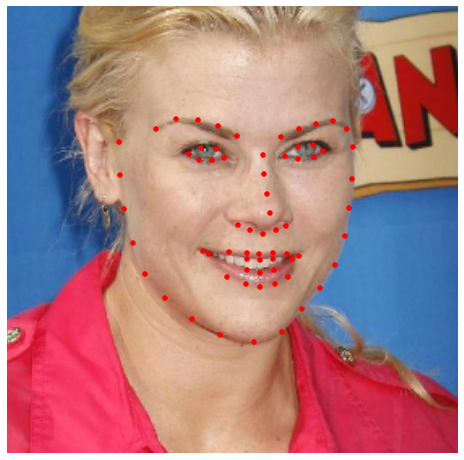

In [26]:
visualize_images(test_images)

## Fit Active Appearance Models

In [52]:
n_shape = [3, 12]
n_appearance = 0.75
max_iters = [24, 16]
scale = 0.5
noise_percentage = 0.05

repeat = 3

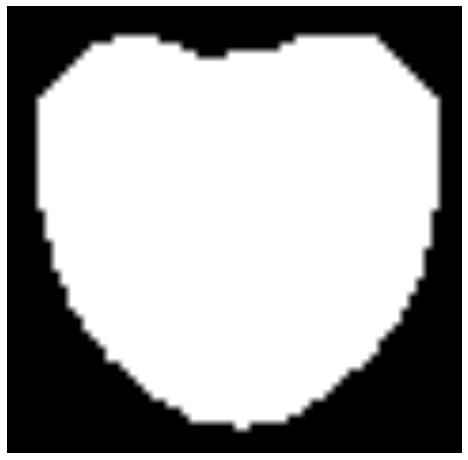

In [53]:
sampling_step_1, sampling_mask_1 = holistic_sampling_from_scale(aam.appearance_models[0].mean(), 
                                                                scale=np.minimum(2 * scale, 1))

sampling_mask_1.view()

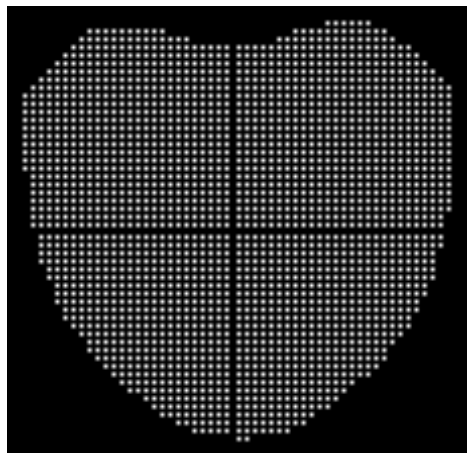

In [54]:
sampling_step_2, sampling_mask_2 = holistic_sampling_from_scale(aam.appearance_models[1].mean(), scale=scale)

sampling_mask_2.view()

In [55]:
sampling_step = [sampling_step_1, sampling_step_2]

#### AAM Fitter

In [56]:
algorithms = [SSDForwardGaussNewtonSimultaneous,
              SSDForwardGaussNewtonAlternated,
              SSDInverseGaussNewtonSimultaneous,
              SSDInverseGaussNewtonAlternated,
              SSDAsymmetricGaussNewtonSimultaneous,
              SSDAsymmetricGaussNewtonAlternated,
              SSDBidirectionalGaussNewtonSimultaneous,
              SSDBidirectionalGaussNewtonAlternated]

fitters = []
for algorithm in algorithms:

    fitter = LucasKanadeAAMFitter(
        aam, 
        lk_algorithm_cls=partial(algorithm),
        n_shape=n_shape, 
        n_appearance=n_appearance,
        sampling=sampling_step)
    
    fitters.append(fitter)

In [57]:
sm_0 = fitter.aam.shape_models[0]
sm_1 = fitter.aam.shape_models[1]

print '1st scale -> \tvariance:', sm_0.variance_ratio(), '\tcomponents:', sm_0.n_active_components
print '2nd scale -> \tvariance:', sm_1.variance_ratio(), '\tcomponents:', sm_1.n_active_components

am_0 = fitter.aam.appearance_models[0]
am_1 = fitter.aam.appearance_models[1]

print '1st scale -> \tvariance:', am_0.variance_ratio(), '\tcomponents:', am_0.n_active_components
print '2nd scale -> \tvariance:', am_1.variance_ratio(), '\tcomponents:', am_1.n_active_components

1st scale -> 	variance: 0.757695862498 	components: 3
2nd scale -> 	variance: 0.926468444778 	components: 12
1st scale -> 	variance: 0.750517836986 	components: 225
2nd scale -> 	variance: 0.75026814791 	components: 280


In [58]:
n_fitters = len(fitters)
legend_entries = ['Initialization', 
                  'SSD_For_GN_Sch',
                  'SSD_For_GN_Alt',
                  'SSD_Inv_GN_Sch',
                  'SSD_Inv_GN_Alt',
                  'SSD_Asy_GN_Sch',
                  'SSD_Asy_GN_Alt',
                  'SSD_Bid_GN_Sch', 
                  'SSD_Bid_GN_Alt']

#### Fitting loop

In [60]:
fitters_results = []
for j, image in enumerate(repeat * test_images):
    
    np.random.seed(j)
    
    gt_shape = image.landmarks['ibug_face_68_trimesh'].lms
    initial_shape = fitters[0].noisy_shape_from_shape(gt_shape, noise_percentage=noise_percentage, rotation=True)

    for fitter in fitters:
        
        fr = fitter.fit_from_shape(image, initial_shape, gt_shape=gt_shape, max_iters=max_iters) 
        fr.downscale = 0.5
        fitters_results.append(fr.as_serializableresult())
    
        print_dynamic(
            'Image: {} - Initial error: {} - Final error: {}'
            .format(j, fr.initial_error(), fr.final_error()))

## Results

In [62]:
mio.export_pickle(fitters_results, result_name + 'ssd_gn.pkl.gz', overwrite=True)

In [5]:
fitters_results = mio.import_pickle(result_name + 'ssd_gn.pkl.gz')

n_fitters = 8
legend_entries = ['Initialization', 
                  'SSD_For_GN_Sch',
                  'SSD_For_GN_Alt',
                  'SSD_Inv_GN_Sch',
                  'SSD_Inv_GN_Alt',
                  'SSD_Asy_GN_Sch',
                  'SSD_Asy_GN_Alt',
                  'SSD_Bid_GN_Sch', 
                  'SSD_Bid_GN_Alt']
max_iters = [24, 16]
noise_percentage = 0.05

Produce CED graph:

In [6]:
errors = [[]]
for fr in fitters_results[::n_fitters]:
    error = compute_normalise_point_to_point_error(fr.initial_shape.points[17:, :], 
                                                   fr.gt_shape.points[17:, :],
                                                   norm_shape=fr.gt_shape.points)
    errors[0].append(error)

for j in range(n_fitters):
    errors_j = []
    for fr in fitters_results[j::n_fitters]:
        error = compute_normalise_point_to_point_error(fr.final_shape.points[17:, :], 
                                                       fr.gt_shape.points[17:, :],
                                                       norm_shape=fr.gt_shape.points)
        errors_j.append(error)
    errors.append(errors_j)

In [88]:
x_axis =  np.arange(0, 0.052, 0.002)

cumulative_errors = []
for err in errors:
    cumulative_errors.append(compute_cumulative_error(err, x_axis))

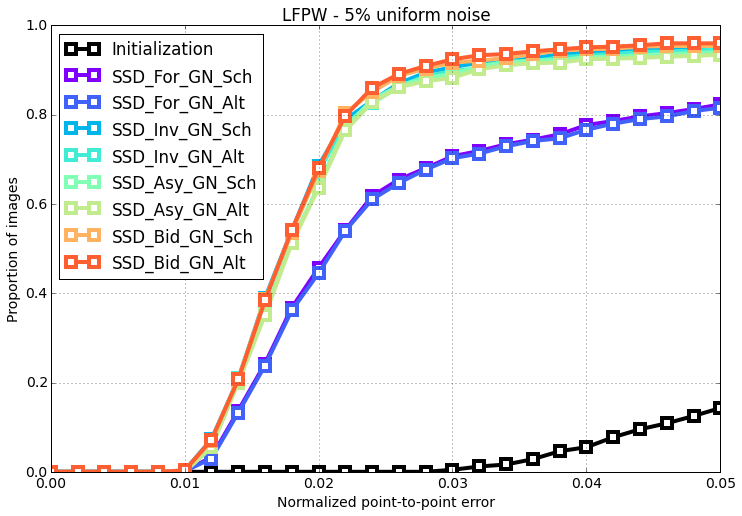

In [91]:
colours = ['black'] + sample_colours_from_colourmap(len(errors)-1, 'rainbow')

fig = plt.figure()
plt.hold(True)

for i in range(len(errors)):
    plt.plot(x_axis,
             cumulative_errors[i],
             color=colours[i],
             linewidth=4,
             marker='s',
             mec=colours[i],
             mfc='w',
             markersize=10,
             mew=4)
    
plt.xlabel('Normalized point-to-point error')
plt.ylabel('Proportion of images')
plt.xlim((x_axis[0], x_axis[-1]))
plt.ylim((0, 1))
plt.legend(legend_entries, loc=2)
plt.grid(True)

plt.title('LFPW - {}% uniform noise '.format(int(100*noise_percentage)))

plt.rcParams.update({'font.size': 14})

fig.set_size_inches(2 * fig.get_size_inches())

plt.savefig(result_name + 'ced_ssd_gn_{}.png'.format(int(100*noise_percentage)), 
            format='png', dpi=300, bbox_inches='tight')

Produce fitting statistics:

In [67]:
for j, e in enumerate(errors):
    print legend_entries[j], '\tmean:', np.mean(e), '\tstd:', np.std(e), '\tmedian:', np.median(e)

Initialization 	mean: 0.0804185853611 	std: 0.0288095928052 	median: 0.0779707986574
SSD_For_GN_Sch 	mean: 0.032922830288 	std: 0.0297162191468 	median: 0.0210761363636
SSD_For_GN_Alt 	mean: 0.0332802346232 	std: 0.0298724526612 	median: 0.0212458462858
SSD_Inv_GN_Sch 	mean: 0.0217688006336 	std: 0.0187044867733 	median: 0.0173669577463
SSD_Inv_GN_Alt 	mean: 0.0222203064274 	std: 0.0196279657845 	median: 0.0174237959497
SSD_Asy_GN_Sch 	mean: 0.0230784213339 	std: 0.0214333158864 	median: 0.0176967115978
SSD_Asy_GN_Alt 	mean: 0.0233310509535 	std: 0.0214794165577 	median: 0.0178329956996
SSD_Bid_GN_Sch 	mean: 0.0217713529888 	std: 0.019411801045 	median: 0.017435387195
SSD_Bid_GN_Alt 	mean: 0.0212481627318 	std: 0.018604638109 	median: 0.0172948931655


Produce mean and median error convergence graphs:

In [7]:
mean_errors = []
std_errors = []
median_errors = []
for j in range(n_fitters):
    errors = []
    for fr in fitters_results[j::n_fitters]:
        errs = []
        for shape in fr.shapes:
            err = compute_normalise_point_to_point_error(shape.points[17:, :], 
                                                         fr.gt_shape.points[17:, :],
                                                         norm_shape=fr.gt_shape.points)            
            errs.append(err)
        while len(errs) < np.sum(max_iters) + aam.n_scales:
            errs.append(errs[-1])
        errors.append(errs)
    mean_errors.append(np.mean(errors, axis=0))
    std_errors.append(np.std(errors, axis=0))
    median_errors.append(np.median(errors, axis=0))

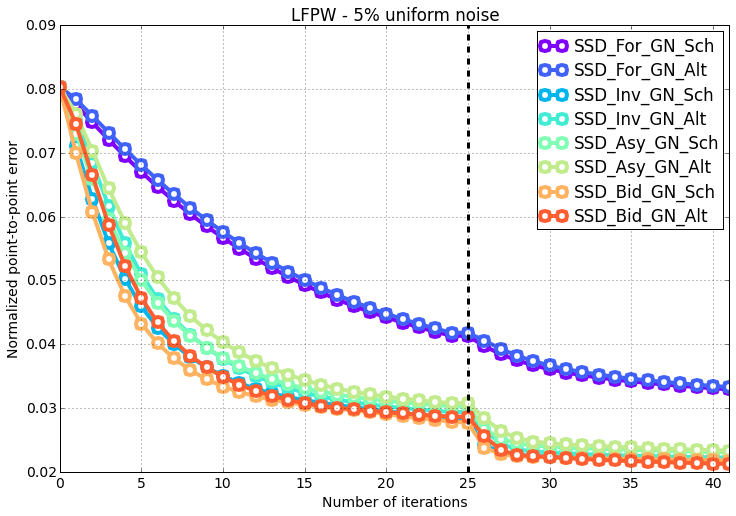

In [11]:
colours = sample_colours_from_colourmap(n_fitters, 'rainbow')

fig = plt.figure()
plt.hold(True)

for i in range(len(mean_errors)):
    plt.plot(np.arange(0, len(mean_errors[i])),
             mean_errors[i],
             color=colours[i],
             linewidth=4,
             marker='o',
             mec=colours[i],
             mfc='w',
             markersize=10,
             mew=4)
    
plt.xlabel('Number of iterations')
plt.ylabel('Normalized point-to-point error')
plt.xlim((0, len(mean_errors[i]) - 1))
plt.ylim((0.02, 0.09))
plt.grid(True)
plt.legend(legend_entries[1:])

xs = (max_iters[0] + 1 , max_iters[0] + 1)
ys = (0.02, 0.09)
plt.plot(xs, ys, 'k--', lw=3)

plt.rcParams.update({'font.size': 14})

plt.title('LFPW - {}% uniform noise '.format(int(100*noise_percentage)))

fig.set_size_inches(2 * fig.get_size_inches())

plt.savefig(result_name + 'mean_error_vs_iters_ssd_gn_{}.png'.format(int(100*noise_percentage)),  
            format='png', dpi=300, bbox_inches='tight')

In [9]:
# colours = sample_colours_from_colourmap(n_fitters, 'rainbow')

# fig = plt.figure()
# plt.hold(True)

# for i in range(len(mean_errors)):
#     plt.plot(np.arange(0, len(mean_errors[i])),
#              median_errors[i],
#              color=colours[i],
#              linewidth=4,
#              marker='o',
#              mec=colours[i],
#              mfc='w',
#              markersize=10,
#              mew=4)
    
# plt.xlabel('Number of iterations')
# plt.ylabel('Normalized point-to-point error')
# plt.xlim((0, len(mean_errors[i]) - 1))
# plt.ylim((0.01, 0.08))
# plt.grid(True)
# plt.legend(legend_entries[1:])

# xs = (max_iters[0] + 1 , max_iters[0] + 1)
# ys = (0.01, 0.08)
# plt.plot(xs, ys, 'k--', lw=3)

# plt.title('LFPW - {}% uniform noise '.format(int(100*noise_percentage)))

# fig.set_size_inches(2 * fig.get_size_inches())

# plt.savefig(result_name + 'median_error_vs_iters_alpha_ssd_gn_{}.png'.format(int(100*noise_percentage)), 
#             format='png', dpi=300, bbox_inches='tight')

Produce mean and median cost convergence graphs:

In [115]:
mean_costs = []
std_costs = []
median_costs = []
for j in range(n_fitters):
    costs = []
    for fr in fitters_results[j::n_fitters]:
        cost = list(fr.costs[:max_iters[0]+1] / fr.costs[0])
        while len(cost) < np.sum(max_iters[0]) + 1:
            cost.append(cost[-1])
        costs.append(cost)
    costs = np.asarray(costs)
    mean_costs.append(np.mean(costs, axis=0))
    std_costs.append(np.std(costs, axis=0))
    median_costs.append(np.median(costs, axis=0))

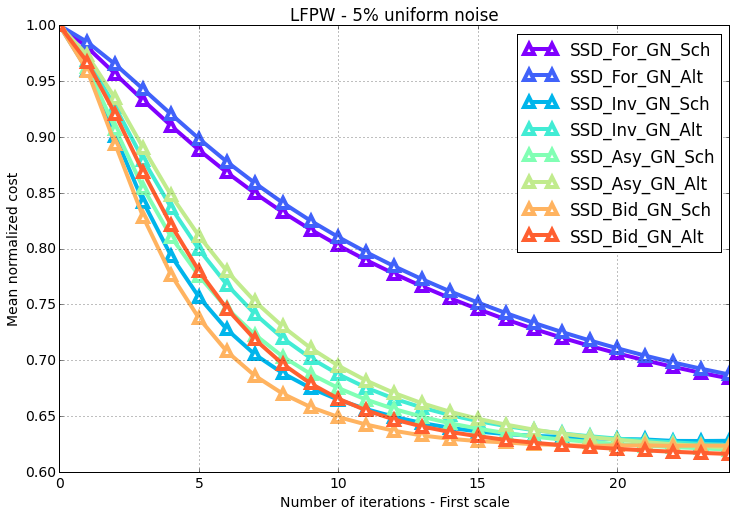

In [129]:
import  matplotlib.pyplot as plt
from menpo.visualize.viewmatplotlib import sample_colours_from_colourmap

colours = sample_colours_from_colourmap(n_fitters, 'rainbow')

fig = plt.figure()
plt.hold(True)


for i in range(len(mean_costs)):
    plt.plot(np.arange(0, len(mean_costs[i])),
             mean_costs[i],
             color=colours[i],
             linewidth=4,
             marker='^',
             mec=colours[i],
             mfc='w',
             markersize=10,
             mew=4)
    
plt.xlabel('Number of iterations - First scale')
plt.ylabel('Mean normalized cost')
plt.xlim((0, len(mean_costs[i]) - 1))
#plt.ylim((0.59, 1.01))
plt.grid(True)
plt.legend(legend_entries[1:])

plt.title('LFPW - {}% uniform noise '.format(int(100*noise_percentage)))

plt.rcParams.update({'font.size': 14})

fig.set_size_inches(2 * fig.get_size_inches())

plt.savefig(result_name + 'mean_cost_vs_iters1_ssd_gn_{}.png'.format(int(100*noise_percentage)), 
            format='png', dpi=300, bbox_inches='tight')

In [131]:
mean_costs = []
std_costs = []
median_costs = []
max_costs = np.zeros(len(fitters_results[0::n_fitters]))
for j in range(n_fitters):
    costs = []
    for k, fr in enumerate(fitters_results[j::n_fitters]):
        if max_costs[k] < fr.costs[max_iters[0] + 1:][0]:
            max_costs[k] = fr.costs[max_iters[0] + 1:][0]
        cost = list(fr.costs[max_iters[0] + 1:])
        while len(cost) < max_iters[1] + 1:
            cost.append(cost[-1])
        costs.append(cost)
    costs = np.asarray(costs) / max_costs[..., None]
    mean_costs.append(np.mean(costs, axis=0))
    std_costs.append(np.std(costs, axis=0))
    median_costs.append(np.median(costs, axis=0))

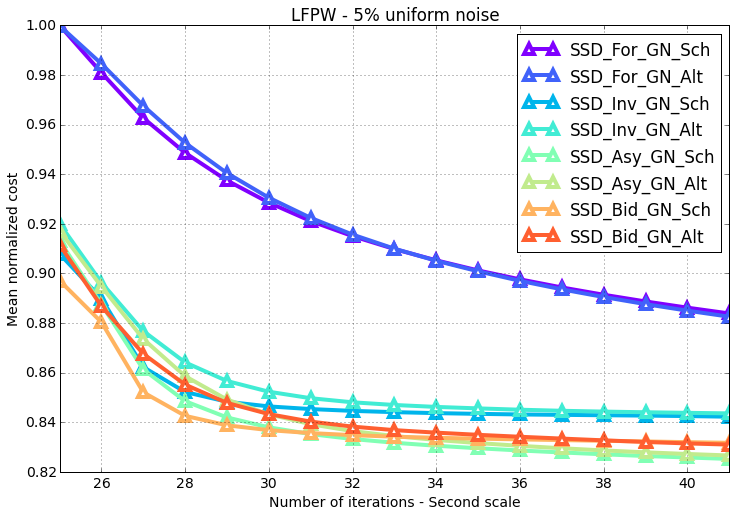

In [132]:
import  matplotlib.pyplot as plt
from menpo.visualize.viewmatplotlib import sample_colours_from_colourmap

colours = sample_colours_from_colourmap(n_fitters, 'rainbow')

fig = plt.figure()
plt.hold(True)


for i in range(len(mean_costs)):
    plt.plot(np.arange(max_iters[0] + 1, np.sum(max_iters)+2),
             mean_costs[i],
             color=colours[i],
             linewidth=4,
             marker='^',
             mec=colours[i],
             mfc='w',
             markersize=10,
             mew=4)
    
plt.xlabel('Number of iterations - Second scale')
plt.ylabel('Mean normalized cost')
plt.xlim((max_iters[0] + 1, np.sum(max_iters)+1))
#plt.ylim((0.82, 1.0))
plt.grid(True)
plt.legend(legend_entries[1:])

plt.title('LFPW - {}% uniform noise '.format(int(100*noise_percentage)))

plt.rcParams.update({'font.size': 14})

fig.set_size_inches(2 * fig.get_size_inches())

plt.savefig(result_name + 'mean_cost_vs_iters2_ssd_gn_{}.png'.format(int(100*noise_percentage)), 
            format='png', dpi=300,  bbox_inches='tight')

Time algorithms:

In [ ]:
%timeit fr = fitters[0].fit_from_shape(image, initial_shape, gt_shape=gt_shape, max_iters=max_iters) 
%timeit fr = fitters[1].fit_from_shape(image, initial_shape, gt_shape=gt_shape, max_iters=max_iters) 
%timeit fr = fitters[2].fit_from_shape(image, initial_shape, gt_shape=gt_shape, max_iters=max_iters) 
%timeit fr = fitters[3].fit_from_shape(image, initial_shape, gt_shape=gt_shape, max_iters=max_iters) 
%timeit fr = fitters[4].fit_from_shape(image, initial_shape, gt_shape=gt_shape, max_iters=max_iters) 
%timeit fr = fitters[5].fit_from_shape(image, initial_shape, gt_shape=gt_shape, max_iters=max_iters) 

For a particular algorithm: 

In [ ]:
visualize_fitting_result(fitters_results[2::n_fitters])

## Other

In [50]:
# import line_profiler
# import IPython

# ip = IPython.get_ipython()
# ip.define_magic('lprun', line_profiler.magic_lprun)

In [51]:
# %lprun -f ProjectOutAsymmetricGaussNewton._solve fitter_3.fit_from_shape(i, s, gt_shape=gt_s, max_iters=2) 